In [1]:


import pandas as pd
import numpy as np
import itertools
import os

import json
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression



%load_ext autoreload
%autoreload 2
%cd /mnt/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from utils.visualization.show_image import show_image
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config
from utils.notebook_utils import *


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *
from src.active_learning.tta_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

import pandas as pd
import numpy as np
import itertools
import os

import json
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression


sns.set(font_scale=1.4)
sns.set(rc={'figure.figsize':(12,6)})


/mnt/activeCell-ACDC
README.md    experiments	notebooks	  shell_scripts
ac_acdc_env  jupyter_notebooks	output		  src
al_output    log		pipeline_configs  utils
data	     nohup.out		requirements.txt  wandb


/mnt/activeCell-ACDC/ac_acdc_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "./experiments/results"

def load_experiment_results(path, experiment_dir, filename):
    
    path = os.path.join(path,experiment_dir)

    directory = os.fsencode(path)
    df_full = None

    for file in os.listdir(directory):
        fn = os.fsdecode(file)
        if fn.find(filename) != -1: 

            df = pd.read_csv(os.path.join(path, fn))

            if len(df) == 1:
                continue

            #print(fn)
            if df_full is None:
                df_full = df
            else:
                df_full=  pd.concat([df_full, df])
        else:
            print("file ignored:", fn)
    
    return df_full

def latex_pd(df):
    df = df.round(5)
    return df.to_latex(index=False)

In [3]:
df = load_experiment_results(path, "tta_stability", "results")

file ignored: .ipynb_checkpoints


In [4]:
df["frame_id"] = df["image_id"].str.split("_").str[-1].astype("int")
df["experiment"] = df["image_id"].str.split("_").str[:-1].str.join("_")
df["certainty"] = 1 - df["agg_uncertainty"]

df = df[df["num_mc_samples"] == 30]

df.head()

,Unnamed: 0,num_mc_samples,max_noise,model_train_size,image_id,run_id,agg_uncertainty,frame_id,experiment,certainty
0,0,30,0.001,15,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,0,0.550150,0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5,0.449850
1,1,30,0.001,15,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,1,0.719745,0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5,0.280255
2,2,30,0.001,15,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,2,0.575471,0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5,0.424529
3,3,30,0.001,15,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,3,0.619881,0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5,0.380119
4,4,30,0.001,15,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,4,0.603994,0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5,0.396006


In [5]:
avg_var = df[["image_id", "certainty","model_train_size","num_mc_samples", "max_noise"]].groupby(["image_id","model_train_size"]).agg("var").reset_index().groupby("model_train_size").agg("mean")
var_ds = df[df["run_id"] == 0][["image_id", "certainty","model_train_size"]].groupby(["image_id","model_train_size"]).agg("mean").reset_index().groupby("model_train_size").agg("var")

df_new = pd.merge(var_ds,avg_var, on="model_train_size").reset_index()
df_new["noise_portion"] = df_new["certainty_y"]/df_new["certainty_x"] 



print(latex_pd(df_new))



\begin{tabular}{rrrrrr}
\toprule
 model\_train\_size &  certainty\_x &  certainty\_y &  num\_mc\_samples &  max\_noise &  noise\_portion \\
\midrule
               15 &      0.00299 &      0.00094 &             0.0 &        0.0 &        0.31503 \\
              240 &      0.00548 &      0.00043 &             0.0 &        0.0 &        0.07856 \\
             3000 &      0.00949 &      0.00040 &             0.0 &        0.0 &        0.04226 \\
             5800 &      0.00857 &      0.00035 &             0.0 &        0.0 &        0.04035 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_861150/582066479.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_var = df[["image_id", "certainty","model_train_size","num_mc_samples", "max_noise"]].groupby(["image_id","model_train_size"]).agg("var").reset_index().groupby("model_train_size").agg("mean")
/tmp/ipykernel_861150/582066479.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  var_ds = df[df["run_id"] == 0][["image_id", "certainty","model_train_size"]].groupby(["image_id","model_train_size"]).agg("mean").reset_index().groupby("model_train_size").agg("var")
/tmp/ipykernel_861150/2167838137.py:31: FutureWarning: In future vers

/tmp/ipykernel_861150/4194587647.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="model_train_size",palette=sns.color_palette())


TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5


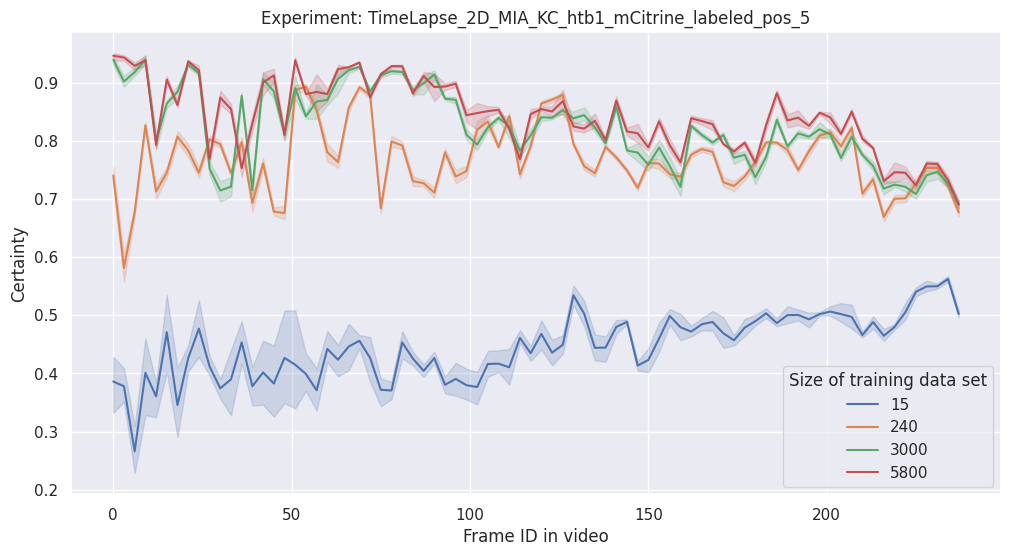

acdc_data2_F016_pos_3


/tmp/ipykernel_861150/4194587647.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="model_train_size",palette=sns.color_palette())


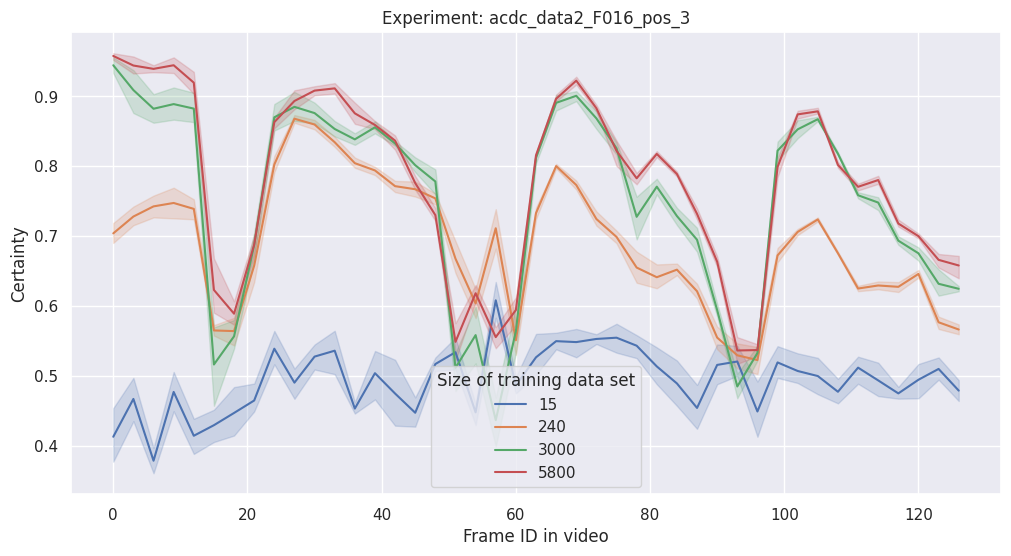

acdc_data2_kurt_306-3_0_20201028_pos_1


/tmp/ipykernel_861150/4194587647.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="model_train_size",palette=sns.color_palette())


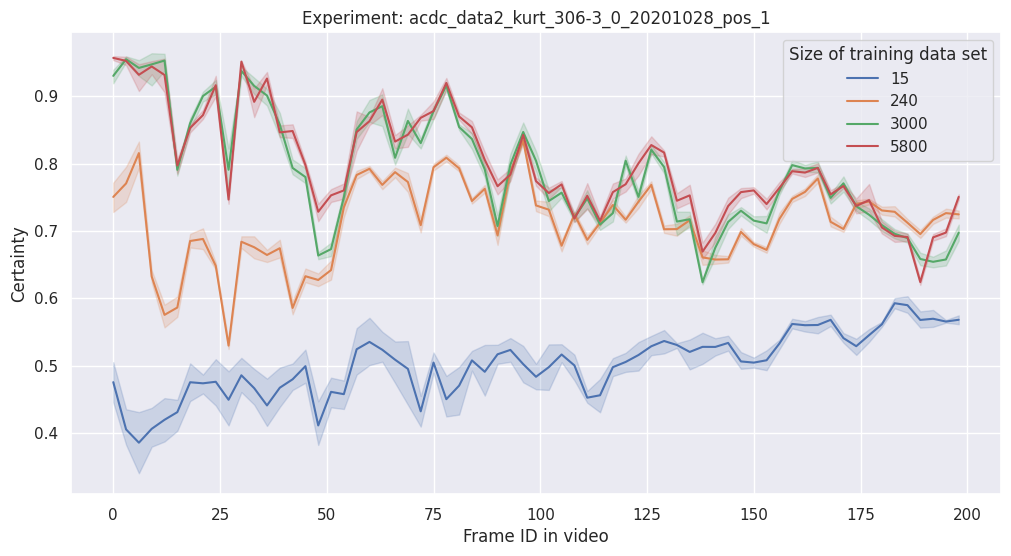

acdc_data3_20210722_pos_18


/tmp/ipykernel_861150/4194587647.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="model_train_size",palette=sns.color_palette())


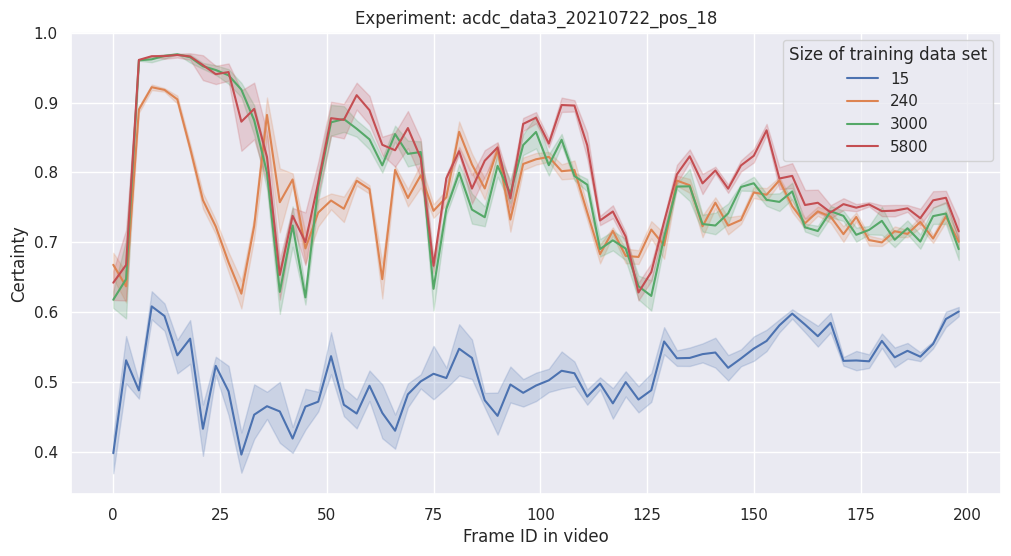

acdc_data3_20210722_pos_2


/tmp/ipykernel_861150/4194587647.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="model_train_size",palette=sns.color_palette())


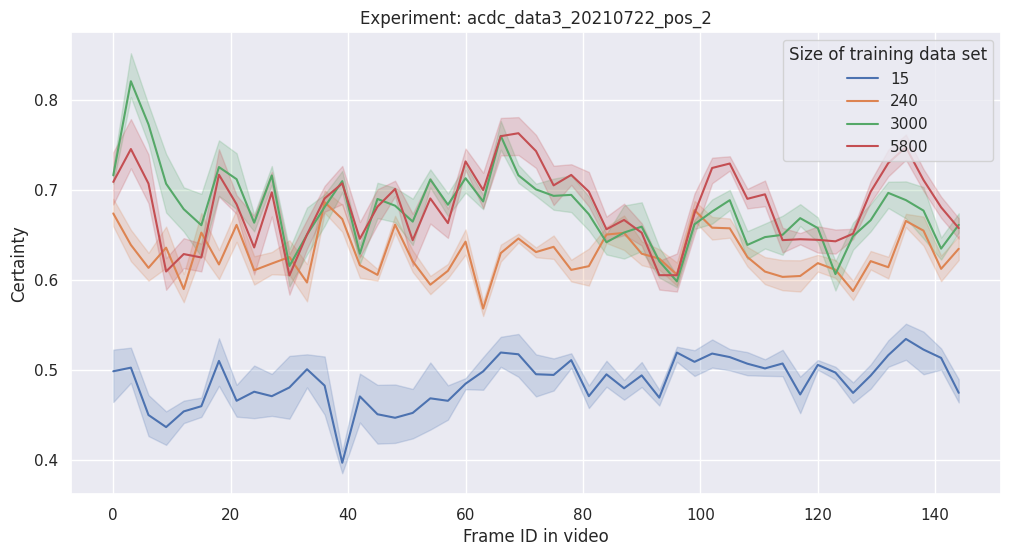

acdc_data3_20210722_pos_5


/tmp/ipykernel_861150/4194587647.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="model_train_size",palette=sns.color_palette())


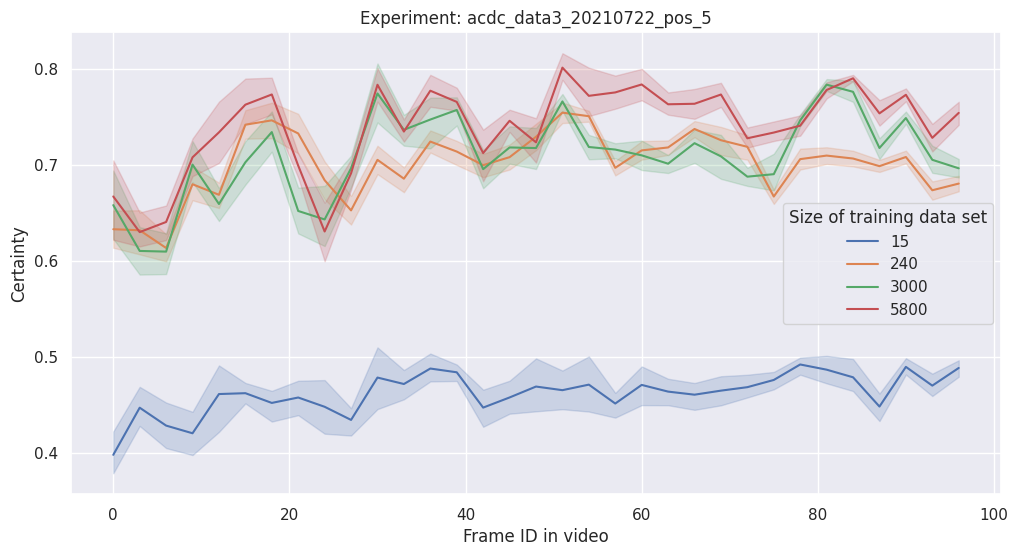

acdc_data3_20211029_pos_1


/tmp/ipykernel_861150/4194587647.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="model_train_size",palette=sns.color_palette())


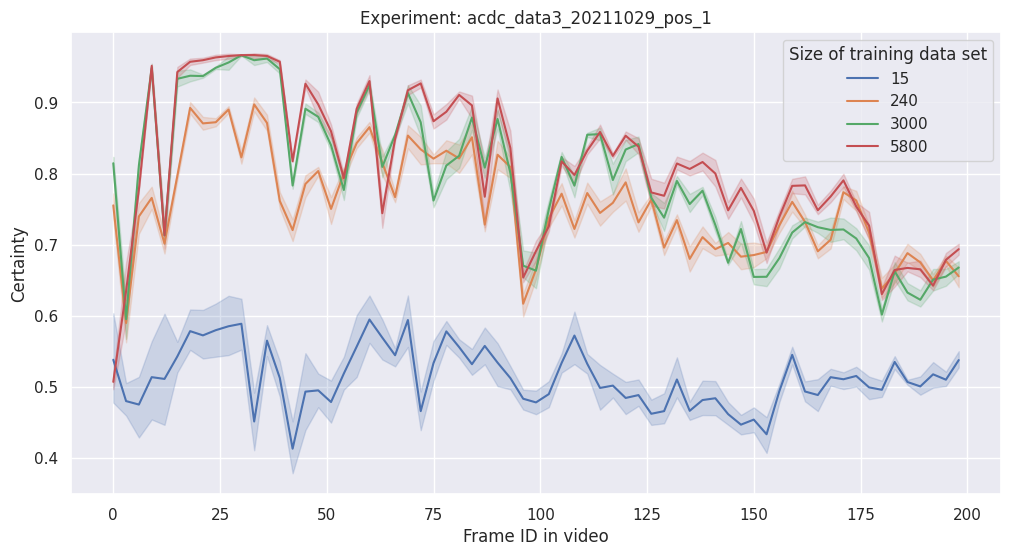

acdc_data3_20211029_pos_4


/tmp/ipykernel_861150/4194587647.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="model_train_size",palette=sns.color_palette())


KeyboardInterrupt: 

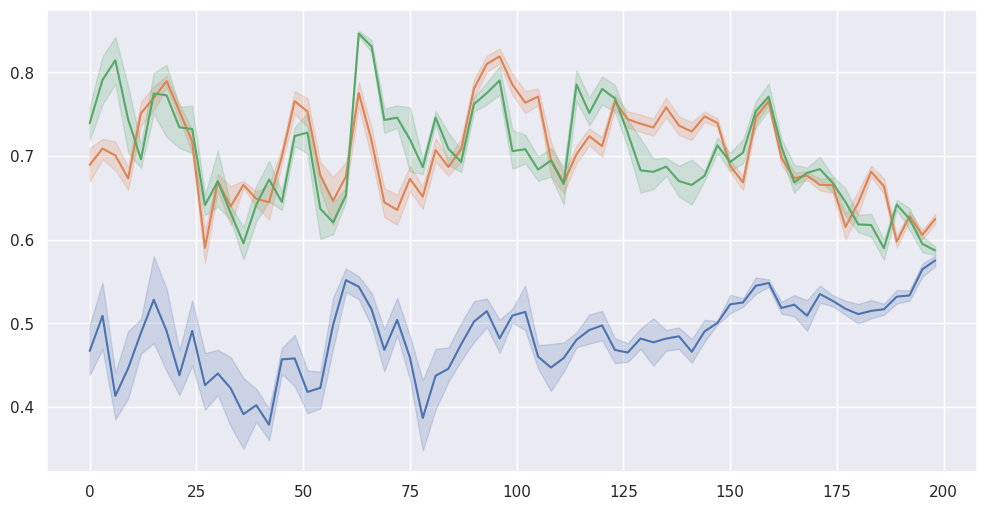

In [6]:
for experiment in df["experiment"].unique():
    df_tmp = df[df["experiment"] == experiment]
    print(experiment)
    plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty", hue="model_train_size",palette=sns.color_palette())
    plot.set(xlabel ="Frame ID in video", ylabel = "Certainty", title =f'Experiment: {experiment}')
    plt.legend(title='Size of training data set')
    plt.show()

In [ ]:
sns.pairplot(df)

In [7]:
dataset = ACDC_LARGE_CLS
register_datasets()
train_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][0]
))

test_data = DatasetCatalog.get("acdc_large_cls_test_slim")

registering acdc_large dataset
registering acdc_large_cls dataset


In [8]:
data_categories = []
for data_json in test_data:
    categories = [annotation["category_id"] for annotation in data_json["annotations"]]
    counts = {i:categories.count(i) for i in range(3)}
    data_categories.append(
        {
            "image_id": data_json["image_id"],
            "G1": counts[0],
            "mother": counts[1],
            "bud": counts[2],
        }
    )
    
category_df = pd.DataFrame.from_records(data_categories)
df_new = pd.merge(df, category_df, left_on="image_id", right_on="image_id")
df_new = df_new[df_new["model_train_size"] == 3000]
df_new.head()

,Unnamed: 0,num_mc_samples,max_noise,model_train_size,image_id,run_id,agg_uncertainty,frame_id,experiment,certainty,G1,mother,bud
5,0,30,0.001,3000,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,0,0.054427,0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5,0.945573,0,1,1
6,1,30,0.001,3000,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,1,0.076532,0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5,0.923468,0,1,1
7,2,30,0.001,3000,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,2,0.062522,0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5,0.937478,0,1,1
8,3,30,0.001,3000,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,3,0.057448,0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5,0.942552,0,1,1
9,4,30,0.001,3000,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0,4,0.054073,0,TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5,0.945927,0,1,1


acdc_data2_F016_pos_3


/tmp/ipykernel_861150/1178544540.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")


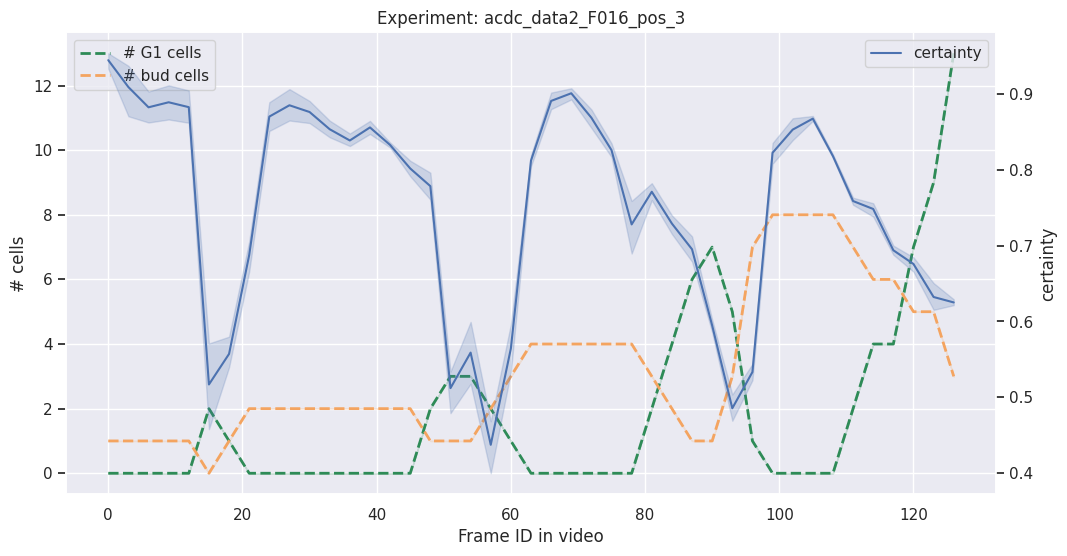

In [30]:
experiment = "acdc_data2_F016_pos_3"

#for experiment in df_new["experiment"].unique():
df_tmp = df_new[df_new["experiment"] == experiment]
print(experiment)
fig = plt.figure()
ax2 = plt.subplot()
g1 = sns.lineplot(data=df_tmp, x="frame_id", y="G1", color="seagreen", ax=ax2, label="# G1 cells",linewidth = 2, linestyle = "dashed")
buds = sns.lineplot(data=df_tmp, x="frame_id", y="bud", color="sandybrown", ax=ax2, label="# bud cells",linewidth = 2, linestyle = "dashed")
ax = plt.twinx()
plot = sns.lineplot(data=df_tmp, x="frame_id", y="certainty",palette=sns.color_palette(), label="certainty")
ax2.set_ylabel("# cells")


#lns = [plot, g1, buds]
#labs = [l.get_label() for l in lns]
#ax2.legend(lns, labs, loc=0)


ax2.set(xlabel ="Frame ID in video", title =f'Experiment: {experiment}')
plot.legend()
ax.grid(False)
ax2.grid(True)
ax2.legend(loc='upper left')
ax.legend(loc='upper right')
#plt.legend(title='Size of training data set')
plt.show()